In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import os
from pyDOE import lhs
import shutil

# Solving PDEs based on Neural Networks

## PDE

Consider Poisson equation
$$
\left\{
\begin{array}{rl}
-\nabla \cdot a \nabla u(\boldsymbol x) = f(\boldsymbol x), & \boldsymbol x \in \Omega\\
u(\boldsymbol x) = g(\boldsymbol x), & \boldsymbol x \in \partial \Omega
\end{array}
\right.
$$

Let $\Omega \in [0, 1]^2$, $u=\sin(2\pi x)\sin(2\pi y)$.

In [2]:
class Problem(object):
    """Description of Poisson equation"""
    def __init__(self, domain=(0, 1, 0, 1)):
        self.domain = domain
        
    def __repr__(self):
        return f'{self.__doc__}'
    
    
    def u(self, x, order=0, verbose=None):
        temp = np.sin(2*np.pi*x[:, [0]]) * np.sin(2*np.pi*x[:, [1]])
        if order == 0:
            out = temp
        elif order == 1:
            u_x = 2*np.pi * np.cos(2*np.pi*x[:, [0]]) * np.sin(2*np.pi*x[:, [1]])
            u_y = 2*np.pi * np.sin(2*np.pi*x[:, [0]]) * np.cos(2*np.pi*x[:, [1]])
            out = np.hstack((u_x, u_y))
        elif order == 2:
            u_xx = - (2*np.pi)**2 * temp
            u_yy = u_xx
            out = np.hstack((u_xx, u_yy))
        
        if verbose == 'tensor':
            return torch.from_numpy(out).float()
        return out
    
    def a(self, x, order=0, verbose=None):
        if order == 0:
            out = np.ones_like(x[:, [0]])
        elif order == 1:
            a_x = np.zeros_like(x[:, [0]])
            a_y = a_x
            out = np.hstack((a_x, a_y))
        
        if verbose == 'tensor':
            return torch.from_numpy(out).float()
        return out
    
    def f(self, x, verbose=None):
        a     = self.a(x, order=0, verbose=verbose)
        a_1st = self.a(x, order=1, verbose=verbose)

        u     = self.u(x, order=0, verbose=verbose)
        u_1st = self.u(x, order=1, verbose=verbose)
        u_2nd = self.u(x, order=2, verbose=verbose)
        
        out = - (a * u_2nd[:, [0]] + a_1st[:, [0]] * u_1st[:, [0]] + 
                 a * u_2nd[:, [1]] + a_1st[:, [1]] * u_1st[:, [1]])
        
        return out
    
    def g(self, x, verbose=None):
        return self.u(x, verbose=verbose)

In [3]:
problem = Problem()
print(problem)

Description of Poisson equation


## Dataset

In [4]:
class Trainset(object):
    def __init__(self, problem, *args, **kwargs):
        self.problem = problem
        self.domain = problem.domain
        self.args = args
        self.method = kwargs['method']
        
    def __call__(self, plot=False, verbose=None):
        if self.method == 'uniform':
            n_x, n_y = self.args[0], self.args[1]
            x, x_bc = self._uniform_sample(n_x, n_y)
        elif self.method == 'lhs':
            n, n_bc = self.args[0], self.args[1]
            x, x_bc = self._lhs_sample(n, n_bc)
        f = self.problem.f(x)
        u = self.problem.u(x)
        g = self.problem.g(x_bc)
        
        if plot:
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.scatter(x[:, 0], x[:, 1], facecolor='r', s=10)
            ax.scatter(x_bc[:, 0], x_bc[:, 1], facecolor='b', s=10)
            ax.set_xlim(-0.01, 1.01)
            ax.set_ylim(-0.01, 1.01)
            ax.set_aspect('equal')
            plt.show()
            
        if verbose is not None:
            x = torch.from_numpy(x).float()
            x_bc = torch.from_numpy(x_bc).float()
            u = torch.from_numpy(u).float()
            f = torch.from_numpy(f).float()
            g = torch.from_numpy(g).float()
            return x, x_bc, u, f, g
        return x, x_bc, u, f, g
        
    def _uniform_sample(self, n_x, n_y):
        x_min, x_max, y_min, y_max = self.domain
        x = np.linspace(x_min, x_max, n_x)
        y = np.linspace(y_min, y_max, n_y)
        x, y = np.meshgrid(x, y)
        xy = np.hstack((x.reshape(x.size, -1), y.reshape(y.size, -1)))
        
        mask = (xy[:, 0] - x_min) * (x_max - xy[:, 0]) * (xy[:, 1] - y_min) * (y_max - xy[:, 1]) == 0
        x_bc = xy[mask]
        x = xy[np.logical_not(mask)]

        return x, x_bc
        
    def _lhs_sample(self, n, n_bc):
        x_min, x_max, y_min, y_max = self.domain

        lb = np.array([x_min, y_min])
        ub = np.array([x_max, y_max])
        x = lb + (ub - lb) * lhs(2, n)

        lb = np.array([x_min, y_min])
        ub = np.array([x_max, y_min])
        x_bc = lb + (ub - lb) * lhs(2, n_bc//4)

        lb = np.array([x_min, y_max])
        ub = np.array([x_max, y_max])
        temp = lb + (ub - lb) * lhs(2, n_bc//4)
        x_bc = np.vstack((x_bc, temp))

        lb = np.array([x_min, y_min])
        ub = np.array([x_min, y_max])
        temp = lb + (ub - lb) * lhs(2, n_bc//4)
        x_bc = np.vstack((x_bc, temp))

        lb = np.array([x_max, y_min])
        ub = np.array([x_max, y_max])
        temp = lb + (ub - lb) * lhs(2, n_bc//4)
        x_bc = np.vstack((x_bc, temp))
        
        return x, x_bc

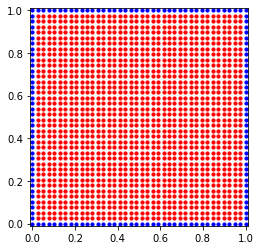

In [5]:
problem = Problem()
trainset = Trainset(problem, 40, 40, method='uniform')
#trainset = Trainset(problem, 1000, 400, method='lhs')

x, x_bc, u, f, g = trainset(plot=True)

In [6]:
class Testset(object):
    """Dataset on a square domain"""
    def __init__(self, problem, *args, **kwargs):
        self.problem = problem
        self.domain = problem.domain
        self.args = args
        self.method = kwargs['method']

    def __repr__(self):
        return f'{self.__doc__}'
        
    def __call__(self, plot=False, verbose=None):
        if self.method == 'uniform':
            n_x, n_y = self.args[0], self.args[1]
            X, x, y = self._uniform_sample(n_x, n_y)
        u = self.problem.u(X)
        u = u.reshape(x.shape)
        
        if plot == True:
            fig = plt.figure()
            ax = fig.add_subplot(121)
            ax.scatter(X[:, 0], X[:, 1], facecolor='r', s=10)
            ax.set_xlim(-0.01, 1.01)
            ax.set_ylim(-0.01, 1.01)
            ax.set_aspect('equal')
            
            ax = fig.add_subplot(122, projection='3d')
            ax.plot_surface(x, y, u, cmap=cm.coolwarm)
            plt.show() 
            
        if verbose == 'tensor':
            X = torch.from_numpy(X).float()
            
        return X, x, y, u

    
    def _uniform_sample(self, n_x, n_y):
        x_min, x_max, y_min, y_max = self.domain
        x = np.linspace(x_min, x_max, n_x)
        y = np.linspace(y_min, y_max, n_y)
        x, y = np.meshgrid(x, y)
        X = np.hstack((x.reshape(x.size, -1), y.reshape(y.size, -1)))
        return X, x, y


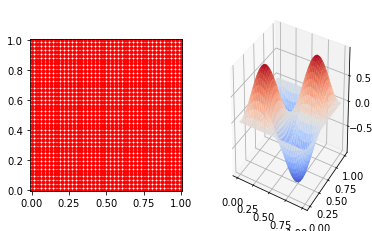

In [7]:
testset = Testset(problem, 40, 40, method='uniform')
X, x, y, u = testset(plot=True)

## Network Archetecture

### Deep Neural Network

In [8]:
def activation(name):
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['leaky_relu', 'LeakyReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus()
    else: 
        raise ValueError(f'unknown activation function: {name}')

In [9]:
class DNN(nn.Module):
    """Deep Neural Network"""
    def __init__(self, dim_in, dim_out, dim_hidden, hidden_layers, act_name='tanh', init_name=None):
        super().__init__()
        model = nn.Sequential()
        
        model.add_module('fc0', nn.Linear(dim_in, dim_hidden, bias=True))
        model.add_module('act0', activation(act_name))
        for i in range(1, hidden_layers):
            model.add_module(f'fc{i}', nn.Linear(dim_hidden, dim_hidden, bias=True))
            model.add_module(f'act{i}', activation(act_name))
        model.add_module(f'fc{hidden_layers}', nn.Linear(dim_hidden, dim_out, bias=True))
        
        self.model = model
        if init_name is not None:
            self.init_weight(init_name)
            
    def init_weight(self, name):
        if name == 'xavier_normal':
            nn_init = nn.init.xavier_normal_
        elif name == 'xavier_uniform':
            nn_init = nn.init.xavier_uniform_
        elif name == 'kaiming_normal':
            nn_init = nn.init.kaiming_normal_
        elif name == 'kaiming_uniform':
            nn_init =  nn.init.kaiming_uniform_
        else:
            raise ValueError(f'unknown initialization function: {name}')
    
        for param in self.parameters():
            if len(param.shape) > 1:
                nn_init(param)
                
    def forward(self, x):
        return self.model(x)
    
    def forward_test(self, x):
        print(f"{'input':<20}{str(x.shape):<40}")
        for name, module in self.model._modules.items():
              x = module(x)
              print(f"{name:<20}{str(x.shape):<40}")
        return x              
    
    def model_size(self):
        n_params = 0
        for param in self.parameters():
            n_params += param.numel()
        return n_params                

In [10]:
model = DNN(2, 1, 20, 4, init_name='kaiming_normal')
print(model)
print(model.model_size())

DNN(
  (model): Sequential(
    (fc0): Linear(in_features=2, out_features=20, bias=True)
    (act0): Tanh()
    (fc1): Linear(in_features=20, out_features=20, bias=True)
    (act1): Tanh()
    (fc2): Linear(in_features=20, out_features=20, bias=True)
    (act2): Tanh()
    (fc3): Linear(in_features=20, out_features=20, bias=True)
    (act3): Tanh()
    (fc4): Linear(in_features=20, out_features=1, bias=True)
  )
)
1341


In [11]:
x = torch.randn(5, 2)
y = model.forward_test(x)

input               torch.Size([5, 2])                      
fc0                 torch.Size([5, 20])                     
act0                torch.Size([5, 20])                     
fc1                 torch.Size([5, 20])                     
act1                torch.Size([5, 20])                     
fc2                 torch.Size([5, 20])                     
act2                torch.Size([5, 20])                     
fc3                 torch.Size([5, 20])                     
act3                torch.Size([5, 20])                     
fc4                 torch.Size([5, 1])                      


### Residual DNN

In [12]:
class ResBlock(nn.Module):
    def __init__(self, dim_in, dim_out, dim_hidden, act_name='tanh'):
        super().__init__()
        
        assert(dim_in == dim_out)
        
        block = nn.Sequential()
        block.add_module('act', activation(act_name))
        block.add_module('fc0', nn.Linear(dim_in, dim_hidden, bias=True))
        block.add_module('fc1', nn.Linear(dim_hidden, dim_out, bias=True))
        self.block = block
        
    def forward(self, x):
        res = x
        out = self.block(x)
        return res + out

In [13]:
class ResDNN(nn.Module):
    def __init__(self, dim_in, dim_out, dim_hidden, res_blocks, act_name='tanh', init_name='kaiming_normal'):
        super().__init__()
        
        model = nn.Sequential()
        model.add_module('fc_first', nn.Linear(dim_in, dim_hidden, bias=True))
        for i in range(res_blocks):
            res_block = ResBlock(dim_hidden, dim_hidden, dim_hidden, act_name=act_name)
            model.add_module(f'res_block{i+1}', res_block)
        model.add_module('act_last', activation(act_name))
        model.add_module('fc_last', nn.Linear(dim_hidden, dim_out, bias=True))
        
        self.model = model
        if init_name is not None:
            self.init_weight(init_name)
        
    def init_weight(self, name):
        if name == 'xavier_normal':
            nn_init = nn.init.xavier_normal_
        elif name == 'xavier_uniform':
            nn_init = nn.init.xavier_uniform_
        elif name == 'kaiming_normal':
            nn_init = nn.init.kaiming_normal_
        elif name == 'kaiming_uniform':
            nn_init =  nn.init.kaiming_uniform_
        else:
            raise ValueError(f'unknown initialization function: {name}')
    
        for param in self.parameters():
            if len(param.shape) > 1:
                nn_init(param)

    def forward(self, x):
        return self.model(x)

    def forward_test(self, x):
        print(f"{'input':<20}{str(x.shape):<40}")
        for name, module in self.model._modules.items():
              x = module(x)
              print(f"{name:<20}{str(x.shape):<40}")
        return x              
    
    def model_size(self):
        n_params = 0
        for param in self.parameters():
            n_params += param.numel()
        return n_params

In [14]:
model = ResDNN(2, 1, 10, 4, init_name='kaiming_normal')
print(model)
print(model.model_size())

ResDNN(
  (model): Sequential(
    (fc_first): Linear(in_features=2, out_features=10, bias=True)
    (res_block1): ResBlock(
      (block): Sequential(
        (act): Tanh()
        (fc0): Linear(in_features=10, out_features=10, bias=True)
        (fc1): Linear(in_features=10, out_features=10, bias=True)
      )
    )
    (res_block2): ResBlock(
      (block): Sequential(
        (act): Tanh()
        (fc0): Linear(in_features=10, out_features=10, bias=True)
        (fc1): Linear(in_features=10, out_features=10, bias=True)
      )
    )
    (res_block3): ResBlock(
      (block): Sequential(
        (act): Tanh()
        (fc0): Linear(in_features=10, out_features=10, bias=True)
        (fc1): Linear(in_features=10, out_features=10, bias=True)
      )
    )
    (res_block4): ResBlock(
      (block): Sequential(
        (act): Tanh()
        (fc0): Linear(in_features=10, out_features=10, bias=True)
        (fc1): Linear(in_features=10, out_features=10, bias=True)
      )
    )
    (act_la

In [15]:
x = torch.randn(5, 2)
y = model.forward_test(x)

input               torch.Size([5, 2])                      
fc_first            torch.Size([5, 10])                     
res_block1          torch.Size([5, 10])                     
res_block2          torch.Size([5, 10])                     
res_block3          torch.Size([5, 10])                     
res_block4          torch.Size([5, 10])                     
act_last            torch.Size([5, 10])                     
fc_last             torch.Size([5, 1])                      


### Physics Informed Neural Networks (PINN)

In [16]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True)

In [17]:
class PINN(DNN):
    """Physics Constrained Neural Networks
    """
    def __init__(self, dim_in, dim_out, dim_hidden, hidden_layers, act_name='tanh', init_name='xavier_normal'):
        super().__init__(dim_in, dim_out, dim_hidden, hidden_layers, act_name=act_name, init_name=init_name)
        
    def forward(self, problem, x, x_bc=None):
        x.requires_grad_(True)
        u = super().forward(x)

        grad_u = grad(u, x)[0]        
        u_x = grad_u[:, [0]]
        u_y = grad_u[:, [1]]
        u_xx = grad(u_x, x)[0][:, [0]]
        u_yy = grad(u_y, x)[0][:, [1]]

        x.detach_()
        x_ = x.cpu().numpy()        
        a = problem.a(x_, verbose='tensor')
        grad_a = problem.a(x_, order=1, verbose='tensor')
        a_x = grad_a[:, [0]]
        a_y = grad_a[:, [1]]

        f = -( a * u_xx + a_x * u_x + a * u_yy + a_y * u_y )
        
        
        if x_bc is not None:
            g = super().forward(x_bc)
            return u, f, g
        return u, f

In [18]:
class ResPINN(DNN):
    """Physics Constrained Neural Networks
    """
    def __init__(self, dim_in, dim_out, dim_hidden, res_blocks, act_name='tanh', init_name='xavier_normal'):
        super().__init__(dim_in, dim_out, dim_hidden, res_blocks, act_name=act_name, init_name=init_name)
        
    def forward(self, problem, x, x_bc=None):
        x.requires_grad_(True)
        u = super().forward(x)

        grad_u = grad(u, x)[0]        
        u_x = grad_u[:, [0]]
        u_y = grad_u[:, [1]]
        u_xx = grad(u_x, x)[0][:, [0]]
        u_yy = grad(u_y, x)[0][:, [1]]

        x.detach_()
        x_ = x.cpu().numpy()        
        a = problem.a(x_, verbose='tensor')
        grad_a = problem.a(x_, order=1, verbose='tensor')
        a_x = grad_a[:, [0]]
        a_y = grad_a[:, [1]]

        f = -( a * u_xx + a_x * u_x + a * u_yy + a_y * u_y )
        
        if x_bc is not None:
            g = super().forward(x_bc)
            return u, f, g
        return u, f

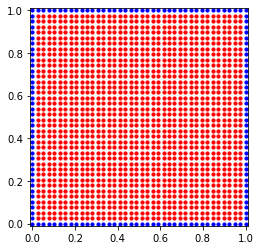

In [19]:
problem = Problem()
trainset = Trainset(problem, 40, 40, method='uniform')
#trainset = Trainset(problem, 1000, 400, method='lhs')

x, x_bc, u, f, g = trainset(plot=True, verbose='tensor')

In [20]:
model = PINN(2, 1, 10, 8)
print(model.model_size())

u_pred, f_pred, g_pred = model(problem, x, x_bc)
print(u_pred.shape, f_pred.shape, g_pred.shape)

811
torch.Size([1444, 1]) torch.Size([1444, 1]) torch.Size([156, 1])


In [21]:
model = ResPINN(2, 1, 10, 4)
print(model.model_size())

u_pred, f_pred, g_pred = model(problem, x, x_bc)
print(u_pred.shape, f_pred.shape, g_pred.shape)

371
torch.Size([1444, 1]) torch.Size([1444, 1]) torch.Size([156, 1])


## Options

In [22]:
import argparse

In [23]:
class Options(object):
    def __init__(self):
        parser = argparse.ArgumentParser()
        parser.add_argument('--no_cuda', action='store_true', default=False, help='disable CUDA or not')
        parser.add_argument('--dim_hidden', type=int, default=10, help='neurons in hidden layers')
        parser.add_argument('--hidden_layers', type=int, default=4, help='number of hidden layers')
        parser.add_argument('--res_blocks', type=int, default=4, help='number of residual blocks')
        parser.add_argument('--dropout', type=float, default=0.5, help='dropout rate')
        parser.add_argument('--lam', type=float, default=1, help='weight in loss function')
        parser.add_argument('--lr', type=float, default=1e-3, help='initial learning rate')
        parser.add_argument('--epochs_Adam', type=int, default=1000, help='epochs for Adam optimizer')
        parser.add_argument('--epochs_LBFGS', type=int, default=200, help='epochs for LBFGS optimizer')
        parser.add_argument('--step_size', type=int, default=2000, help='step size in lr_scheduler for Adam optimizer')
        parser.add_argument('--gamma', type=float, default=0.7, help='gamma in lr_scheduler for Adam optimizer')
        parser.add_argument('--resume', type=bool, default=False, help='resume or not')
        parser.add_argument('--sample_method', type=str, default='lhs', help='sample method')
        parser.add_argument('--n_x', type=int, default=100, help='sample points in x-direction for uniform sample')
        parser.add_argument('--n_y', type=int, default=100, help='sample points in y-direction for uniform sample')
        parser.add_argument('--n', type=int, default=10000, help='sample points in domain for lhs sample')
        parser.add_argument('--n_bc', type=int, default=400, help='sample points on the boundary for lhs sample')
        parser.add_argument('--case', type=int, default=1, help='problem case')
        
        self.parser = parser
    def parse(self):
        arg = self.parser.parse_args(args=[])
        arg.cuda = not arg.no_cuda and torch.cuda.is_available()
        arg.device = torch.device('cpu')#('cuda' if torch.cuda.is_available() else 'cpu')
        return arg


In [24]:
args = Options().parse()
print(args)

Namespace(case=1, cuda=True, device=device(type='cpu'), dim_hidden=10, dropout=0.5, epochs_Adam=1000, epochs_LBFGS=200, gamma=0.7, hidden_layers=4, lam=1, lr=0.001, n=10000, n_bc=400, n_x=100, n_y=100, no_cuda=False, res_blocks=4, resume=False, sample_method='lhs', step_size=2000)


## Training Process

In [25]:
def save_model(state, is_best=None, save_dir=None):
    last_model = os.path.join(save_dir, 'last_model.pth.tar')
    torch.save(state, last_model)
    if is_best:
        best_model = os.path.join(save_dir, 'best_model.pth.tar')
        shutil.copyfile(last_model, best_model)

In [26]:
class Trainer(object):
    def __init__(self, args):
        self.device  = args.device
        self.problem = args.problem
        
        self.lam = args.lam
        self.criterion = nn.MSELoss()
        
        self.model = args.model
        self.model_name = self.model.__class__.__name__
        self.model_path = self._model_path()
                
        self.epochs_Adam = args.epochs_Adam
        self.epochs_LBFGS = args.epochs_LBFGS
        self.optimizer_Adam = optim.Adam(self.model.parameters(), lr=args.lr)
        self.optimizer_LBFGS = optim.LBFGS(self.model.parameters(), max_iter=20, tolerance_grad=1.e-8, tolerance_change=1.e-12)
        self.lr_scheduler = StepLR(self.optimizer_Adam, step_size=args.step_size, gamma=args.gamma)

        self.model.to(self.device)
        self.model.zero_grad()
        
        self.x,     self.x_bc,     _, self.f,     self.g     = args.trainset(verbose='tensor')
        self.x_val, self.x_bc_val, _, self.f_val, self.g_val = args.validset(verbose='tensor')
        
        if self.device == torch.device(type='cuda'):
            for item in [self.x, self.x_bc, self.f, self.g, self.x_val, self.x_bc_val, self.f_val, self.g_val]:
                item = item.to(self.device)
        
    def _model_path(self):
        """Path to save the model"""
        if not os.path.exists('checkpoints'):
            os.mkdir('checkpoints')

        path = os.path.join('checkpoints', self.model_name)
        if not os.path.exists(path):
            os.mkdir(path)
    
        return path
    
    def train(self):
        best_loss = 1.e10
        
        for epoch in range(self.epochs_Adam):
            loss, loss1, loss2 = self.train_Adam()
            if (epoch + 1) % 100 == 0:
                self.infos_Adam(epoch+1, loss, loss1, loss2)
                
                valid_loss = self.validate(epoch)
                is_best = valid_loss < best_loss
                best_loss = valid_loss if is_best else best_loss                
                state = {
                    'epoch': epoch,
                    'state_dict': self.model.state_dict(),
                    'best_loss': best_loss
                }
                save_model(state, is_best, save_dir=self.model_path)
                
            
        for epoch in range(self.epochs_Adam, self.epochs_Adam + self.epochs_LBFGS):
            loss, loss1, loss2 = self.train_LBFGS()
            if (epoch + 1) % 20 == 0:
                self.infos_LBFGS(epoch+1, loss, loss1, loss2)
                
                valid_loss = self.validate(epoch)
                is_best = valid_loss < best_loss
                best_loss = valid_loss if is_best else best_loss                
                state = {
                    'epoch': epoch,
                    'state_dict': self.model.state_dict(),
                    'best_loss': best_loss
                }
                save_model(state, is_best, save_dir=self.model_path)
            
    def train_Adam(self):
        self.optimizer_Adam.zero_grad()

        _, f_pred, g_pred = self.model(self.problem, self.x, self.x_bc)
        loss1 = self.criterion(f_pred, self.f)
        loss2 = self.criterion(g_pred, self.g)
        loss = loss1 + self.lam * loss2

        loss.backward()
        self.optimizer_Adam.step()
        self.lr_scheduler.step()

        return loss.item(), loss1.item(), loss2.item()

    def infos_Adam(self, epoch, loss, loss1, loss2):
        infos = 'Adam  ' + \
            f'Epoch #{epoch:5d}/{self.epochs_Adam+self.epochs_LBFGS} ' + \
            f'Loss: {loss:.4e} = {loss1:.4e} + {self.lam} * {loss2:.4e} ' + \
            f'lr: {self.lr_scheduler.get_lr()[0]:.2e} '
        print(infos)
        
    def train_LBFGS(self):

        # only used to compute loss_int and loss_bc1 for monitoring
        _, f_pred, g_pred = self.model(self.problem, self.x, self.x_bc)
        loss1 = self.criterion(f_pred, self.f)
        loss2 = self.criterion(g_pred, self.g)

        def closure():
            if torch.is_grad_enabled():
                self.optimizer_LBFGS.zero_grad()
            _, f_pred, g_pred = self.model(self.problem, self.x, self.x_bc)               
            loss1 = self.criterion(f_pred, self.f)
            loss2 = self.criterion(g_pred, self.g)
            loss = loss1 + self.lam * loss2
            if loss.requires_grad:
                loss.backward()
            return loss

        self.optimizer_LBFGS.step(closure)
        loss = closure()

        return loss.item(), loss1.item(), loss2.item()
        
    def infos_LBFGS(self, epoch, loss, loss1, loss2):
        infos = 'LBFGS ' + \
            f'Epoch #{epoch:5d}/{self.epochs_Adam+self.epochs_LBFGS} ' + \
            f'Loss: {loss:.2e} = {loss1:.2e} + {self.lam:d} * {loss2:.2e} '
        print(infos)

    def validate(self, epoch):
        self.model.eval()
        _, f_pred, g_pred = self.model(self.problem, self.x_val, self.x_bc_val)
        loss1 = self.criterion(f_pred, self.f_val)
        loss2 = self.criterion(g_pred, self.g_val)
        loss = loss1 + self.lam * loss2
        
        infos = 'Valid ' + \
            f'Epoch #{epoch+1:5d}/{self.epochs_Adam+self.epochs_LBFGS} ' + \
            f'Loss: {loss:.4e} '
        print(infos)
        self.model.train()
        return loss.item()

In [27]:
args = Options().parse()
args.problem = Problem()
#args.model = PINN(dim_in=2,
#                  dim_out=1,
#                  dim_hidden=args.dim_hidden,
 #                 hidden_layers=args.hidden_layers,
 #                 act_name='sin',
 #                 dropout=args.dropout)

args.model = PINN(2, 1, dim_hidden=args.dim_hidden, hidden_layers=args.hidden_layers)
if args.sample_method == 'uniform':
    args.trainset = Trainset(args.problem, args.n_x, args.n_y, method='uniform')
elif args.sample_method == 'lhs':
    args.trainset = Trainset(args.problem, args.n, args.n_bc, method='lhs')

args.validset = Trainset(args.problem, 100, 100, method='uniform')
    
trainer = Trainer(args)
trainer.train()


d:\program files (x86)\python\lib\site-packages\torch\optim\lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Adam  Epoch #  100/1200 Loss: 1.0112e+03 = 1.0090e+03 + 1 * 2.1233e+00 lr: 1.00e-03 
Valid Epoch #  100/1200 Loss: 1.0228e+03 
Adam  Epoch #  200/1200 Loss: 7.8120e+02 = 7.7994e+02 + 1 * 1.2628e+00 lr: 1.00e-03 
Valid Epoch #  200/1200 Loss: 7.8454e+02 
Adam  Epoch #  300/1200 Loss: 6.9282e+02 = 6.9208e+02 + 1 * 7.4079e-01 lr: 1.00e-03 
Valid Epoch #  300/1200 Loss: 6.9761e+02 
Adam  Epoch #  400/1200 Loss: 3.9930e+02 = 3.9827e+02 + 1 * 1.0290e+00 lr: 1.00e-03 
Valid Epoch #  400/1200 Loss: 4.0031e+02 
Adam  Epoch #  500/1200 Loss: 1.3553e+02 = 1.3385e+02 + 1 * 1.6734e+00 lr: 1.00e-03 
Valid Epoch #  500/1200 Loss: 1.2861e+02 
Adam  Epoch #  600/1200 Loss: 5.9201e+01 = 5.7857e+01 + 1 * 1.3436e+00 lr: 1.00e-03 
Valid Epoch #  600/1200 Loss: 5.4779e+01 
Adam  Epoch #  700/1200 Loss: 4.1776e+01 = 4.0504e+01 + 1 * 1.2714e+00 lr: 1.00e-03 
Valid Epoch #  700/1200 Loss: 3.8409e+01 
Adam  Epoch #  800/1200 Loss: 3.3064e+01 = 3.1916e+01 + 1 * 1.1479e+00 lr: 1.00e-03 
Valid Epoch #  800/1200 Lo

# Test Process 

In [28]:
class Tester(object):
    def __init__(self, args):
        self.device  = args.device
        self.problem = args.problem
        self.criterion = nn.MSELoss()
        self.model = args.model
        model_name = self.model.__class__.__name__
        model_path = os.path.join('checkpoints',
                                  model_name,
                                  'best_model.pth.tar')
        best_model = torch.load(model_path)
        self.model.load_state_dict(best_model['state_dict'])        
        self.model.to(self.device)
        self.X, self.x, self.y, self.u = args.testset(verbose='tensor')
        if self.device == torch.device(type='cuda'):
            self.X = self.X.to(self.device)
    
    def predict(self):
        self.model.eval()
        u_pred, _ = self.model(self.problem, self.X)
        u_pred = u_pred.detach().cpu().numpy()
        u_pred = u_pred.reshape(self.x.shape)
        
        fig = plt.figure()
        ax = fig.add_subplot(131, projection='3d')
        ax.plot_surface(self.x, self.y, self.u, cmap=cm.coolwarm)
        ax = fig.add_subplot(132, projection='3d')
        ax.plot_surface(self.x, self.y, u_pred, cmap=cm.coolwarm)
        ax = fig.add_subplot(133, projection='3d')
        ax.plot_surface(self.x, self.y, np.abs(u_pred-self.u), cmap=cm.coolwarm)
        plt.show()

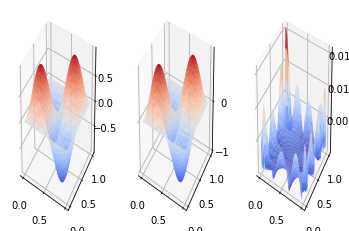

In [29]:
args = Options().parse()
args.problem = Problem()

args.model = ResPINN(2, 1, dim_hidden=args.dim_hidden, res_blocks=args.res_blocks)
args.testset = Testset(args.problem, 100, 100, method='uniform')  
tester = Tester(args)
tester.predict()